In [1]:
import time

# Use multiprocess instead of multiprocessing
#   for notebooks (the latter doesn't work with
#   funcs defined in jupyter).
from multiprocess import Pool

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize

from skimage.transform import (estimate_transform, AffineTransform, EuclideanTransform,
    SimilarityTransform, ProjectiveTransform, PolynomialTransform, PiecewiseAffineTransform)

from neurodsp.sim.cycles import (
    sim_sine_cycle,
    sim_asine_cycle,
    sim_asym_harmonic_cycle,
    sim_exp_cycle,
    sim_2exp_cycle,
    sim_exp_cos_cycle,
    sim_gaussian_cycle, 
    sim_skewed_gaussian_cycle,
    sim_sawtooth_cycle,
    sim_normalized_cycle
)

## Module Code

Below should me moved to .py files.

In [2]:
# bycycle/recon/defaults.py
DEFAULT_OPT = {
    'sine': {
        'phase': {'p0': 0.0, 'bounds': (0.0, 1.0)}
    },
    'asine' :{
        'rdsym' : {'p0': 0.5, 'bounds': (0.0, 1.0)},
        'phase': {'p0': 0.0, 'bounds': (0.0, 1.0)}
    },
    'asym_harmonic': {
        'phi': {'p0': 0.0, 'bounds' : (-10.0, 10.0)},
        'n_harmonics': {'p0': 1, 'bounds': (1, 1)} ,
        'phase': {'p0': 0.0, 'bounds': (0.0, 1.0)}
    },
    # !
    # 2exp needs to be renamed. These names become attrs and
    #   attrs can't start with a number (e.g. self.models.2exp won't work)
    #
    # '2exp': {
    #     'tau_d': {'p0': 0.1, 'bounds': (0.01, 1.0)},
    #     'tau_r': {'p0': 0.05, 'bounds': (0.01, 1.0)},
    #     'phase': {'p0': 0.0, 'bounds': (0.0, 1.0)}
    # },
    'exp_cos': {
        'exp': {'p0': 1.0, 'bounds': (0.1, 10)},
        'phase': {'p0': 0.0, 'bounds': (0.0, 1.0)}
    },
    'gaussian': {
        'std': {'p0': 1.0, 'bounds': (0.01, 1)},
        'phase': {'p0': 0.0, 'bounds': (0.0, 1.0)}
    },
    'skewed_gaussian': {
        'center': {'p0': 0.5, 'bounds': (0.2, 0.8)},
        'std': {'p0': 0.5, 'bounds': (0.1, 0.25)},
        'alpha': {'p0': 0.0, 'bounds': (0.0, 2.0)},
        'phase': {'p0': 0.0, 'bounds': (0.0, 1.0)}
    },
    'sawtooth': {
        'width': {'p0': 0.5, 'bounds': (0.0, 1.0)},
        'phase': {'p0': 0.0, 'bounds': (0.0, 1.0)}
    }
}

BOUNDS = {}
P0 = {}
KEYS = {}

for k in DEFAULT_OPT:
    _bounds = []
    _p0 = []
    for p in DEFAULT_OPT[k]:
        _bounds.append(DEFAULT_OPT[k][p]['bounds'])
        _p0.append(DEFAULT_OPT[k][p]['p0'])
        
    BOUNDS[k] = _bounds
    P0[k] = _p0
    KEYS[k] = list(DEFAULT_OPT[k].keys())

In [3]:
# bycycle/recon/metrics.py
def mse(y_true, cycle_type, keys, dtypes, *params):
    # Minimize mean-squared error
    y_pred = sim_normalized_cycle(
        1, len(y_true), cycle_type,
        **{k: dt(v) for k, dt, v in zip(keys, dtypes, params)}
    )[:len(y_true)]
    
    return ((y_pred-y_true)**2).mean()


def rsq(y_true, cycle_type, keys, dtypes, *params):
    
    # R-squared
    y_pred = sim_normalized_cycle(
        1, len(y_true), cycle_type,
        **{k: dt(v) for k, dt, v in zip(keys, dtypes, params)}
    )[:len(y_true)]
    
    return np.corrcoef(y_true, y_pred)[0][1]**2

In [4]:
from skimage.transform import AffineTransform

# bycycle/recon/metrics.py
def mse_affine(y_true, cycle_type, keys, dtypes, *params):
    """Mean-squared error."""

    params_sim = params[:-9]
    params_affine = np.array(params[-9:]).reshape(3, 3)

    # Simulate
    y_pred = sim_normalized_cycle(
        1, len(y_true), cycle_type,
        **{k: dt(v) for k, dt, v in zip(keys[:-9], dtypes[:-9], params_sim)}
    )[:len(y_true)]
    
    # Affine transform
    x = np.arange(len(y_pred)) 
    src = np.vstack((x, y_pred)).T
    y_pred = AffineTransform(params_affine)(src).T[1]
    
    return ((y_pred-y_true)**2).mean()


def rsq_affine(y_true, cycle_type, keys, dtypes, *params):
    
    params_sim = params[:-9]
    params_affine = np.array(params[-9:]).reshape(3, 3)
    
    # Simulate
    y_pred = sim_normalized_cycle(
        1, len(y_true), cycle_type,
        **{k: dt(v) for k, dt, v in zip(keys[:-9], dtypes[:-9], params_sim)}
    )[:len(y_true)]

    # Affine transform
    x = np.arange(len(y_pred)) 
    src = np.vstack((x, y_pred)).T
    y_pred = AffineTransform(params_affine)(src).T[1]

    return np.corrcoef(y_true, y_pred)[0][1]**2

In [5]:
# bycycle/recon/objs.py
from tqdm.notebook import tqdm

class Models:
    def __init__(self, bases):
        for b in bases:
            setattr(self, b.cycle, b)
            
class Basis:

    def __init__(self, cycle, p0, bounds, param_names):
        self.cycle = cycle
        self.p0 = p0
        self.bounds = bounds
        self.param_names = param_names
        
        self.popt = None
        self.loss = None
        self.rsq = None


class BycycleRecon:

    def __init__(self, cycles=None, affine=True, p0=None, bounds=None, param_names=None):

        self.cycles = list(DEFAULT_OPT.keys()) if cycles is None else cycles
        self.bounds = BOUNDS.copy() if bounds is None else bounds
        self.p0 = P0.copy() if p0 is None else p0
        self.param_names = param_names
        self.affine = affine

        if self.affine:
            names_ext = [f'affine_{i}' for i in range(9)]
            p0_ext = np.eye(3, 3).flatten()
            bounds_ext = [(-10, 10) for _ in range(9)]
            
        if self.param_names is None:
            self.param_names = {}
            for k in DEFAULT_OPT:
                names = list(DEFAULT_OPT[k].keys())
                if self.affine:
                    names.extend(names_ext)
                self.param_names[k] = names

        self._bases = []
        for cyc in self.cycles:
            # Todo: can't use name "2exp" (rename this to something else) in attribute
            #   (e.g. self.models.2exp won't work)
            _p0 = self.p0[cyc].copy()
            _bounds = self.bounds[cyc].copy()
            
            if affine:
                _p0.extend(p0_ext)
                _bounds.extend(bounds_ext)
                
            self._bases.append(Basis(
                cyc, p0=_p0, bounds=_bounds, param_names=self.param_names[cyc]
            ))

        self.models = Models(self._bases)

    @staticmethod
    def _fit(x, models, cycles, affine):

        results = {
            'popt': {},
            'loss': {},
            'rsq': {}
        }
        
        for icyc, cyc_sim in enumerate(cycles):

            model = getattr(models, cyc_sim)
                    
            # Minimize loss
            dtypes = [type(i) for i in model.p0]

            if affine:
                lfunc = lambda params : mse_affine(x, cyc_sim, model.param_names, dtypes, *params)
            else:
                lfunc = lambda params : mse(x, cyc_sim, model.param_names, dtypes, *params)
    
            # Todo: expose some of the import optimization options
            res = minimize(lfunc, model.p0, bounds=model.bounds, method='L-BFGS-B')
    
            results['popt'][cyc_sim] = res.x
            results['loss'][cyc_sim] = res.fun

            if affine:
                results['rsq'][cyc_sim] = rsq_affine(x, cyc_sim, model.param_names, dtypes, *res.x)
            else:
                results['rsq'][cyc_sim] = rsq(x, cyc_sim, model.param_names, dtypes, *res.x)
            
        return results
    
    def fit(self, X, n_jobs=1):

        self._X = X
        
        if n_jobs == 1:
            for icyc, x in enumerate(X):
                    
                _results = self._fit(x, self.models, self.cycles, self.affine)

                for cyc_sim in self.cycles:
                    
                    model = getattr(self.models, cyc_sim)
    
                    # Initalize arrays
                    if model.popt is None:
                        model.popt = np.zeros((len(self._X), len(model.p0)))
                        model.loss = np.zeros(len(self._X))
                        model.rsq = np.zeros(len(self._X))
                        
                    model.popt[icyc] = _results['popt'][cyc_sim]
                    model.loss[icyc] = _results['loss'][cyc_sim]
                    model.rsq[icyc] = _results['rsq'][cyc_sim]
                    
        else:
            
            lfunc = lambda x : self._fit(x, self.models, self.cycles, self.affine)
            
            with Pool(processes=n_jobs) as pool:
                results = list(tqdm(pool.imap(lfunc, X), total=len(X)))

            for icyc in range(len(X)):
                    
                for cyc_sim in self.cycles:
                    
                    model = getattr(self.models, cyc_sim)
    
                    # Initalize arrays
                    if model.popt is None:
                        model.popt = np.zeros((len(self._X), len(model.p0)))
                        model.loss = np.zeros(len(self._X))
                        model.rsq = np.zeros(len(self._X))
                        
                    model.popt[icyc] = results[icyc]['popt'][cyc_sim]
                    model.loss[icyc] = results[icyc]['loss'][cyc_sim]
                    model.rsq[icyc] = results[icyc]['rsq'][cyc_sim]

## Simulate

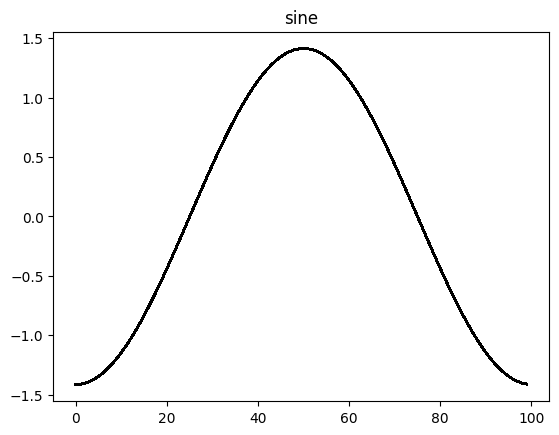

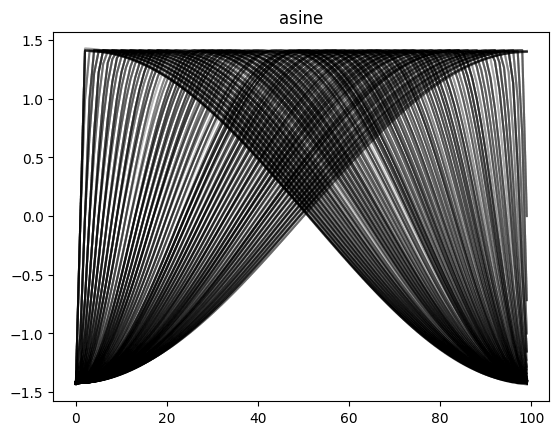

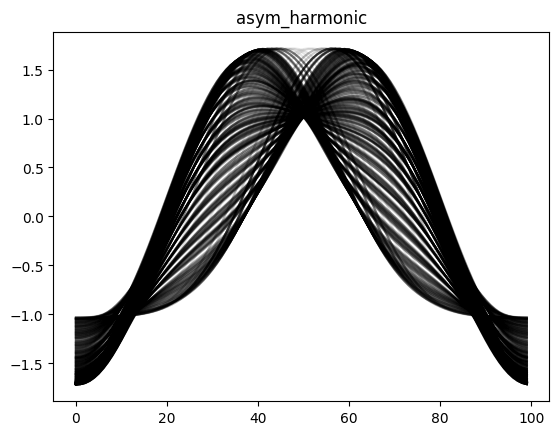

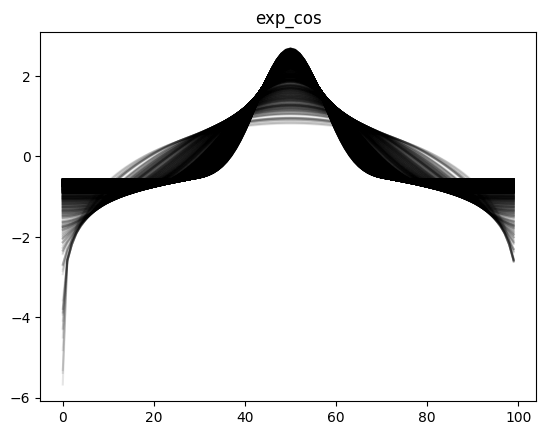

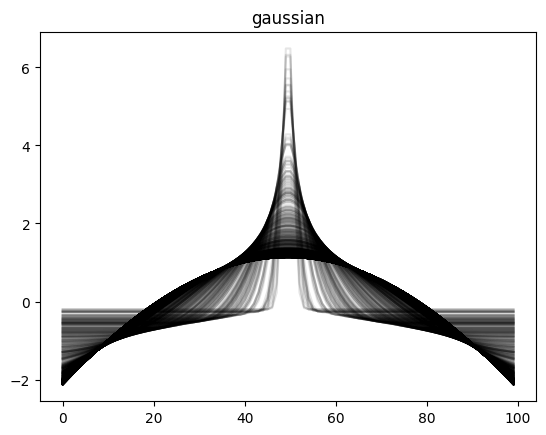

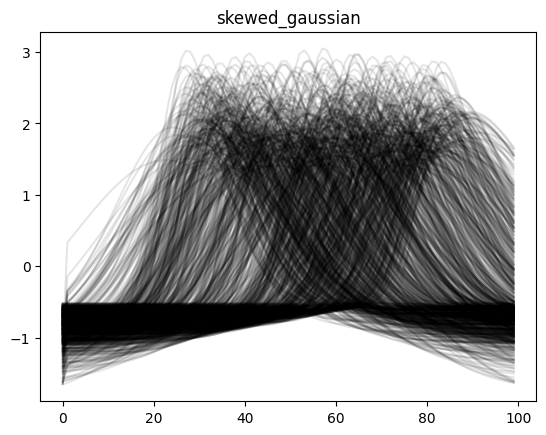

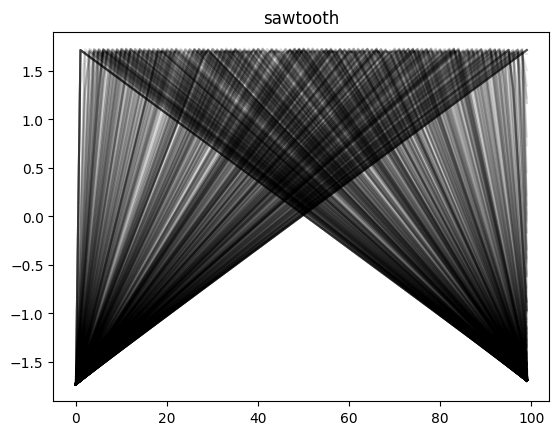

In [6]:
n_sims = 1000

cycle_targets = np.zeros((len(DEFAULT_OPT), n_sims, 100))
target_values = []

for imap, cyc_type in enumerate(DEFAULT_OPT.keys()):

    sim_kwargs = {}
    _types = [type(i) for i in P0[cyc_type]]
    
    for ikwarg, (k, b) in enumerate(zip(KEYS[cyc_type], BOUNDS[cyc_type])):
        sim_kwargs[k] = np.random.uniform(b[0], b[1], n_sims).astype(_types[ikwarg])


    # For each cycle type, run 1000 simulations of randomized parameters
    for isim in range(n_sims):

        kwargs = {k: v[isim] for k, v in sim_kwargs.items() if k != 'phase'}
        
        # Seed and simulate
        np.random.seed(isim)
        cycle_targets[imap, isim] = sim_normalized_cycle(
            1, 100, cyc_type, phase='min', **kwargs
        )[:100]

for ind, i in enumerate(cycle_targets):
    plt.figure()
    for j in i:
        plt.plot(j, color='k', alpha=.1)
    plt.title(list(DEFAULT_OPT.keys())[ind])

## Fit Simulations

Each random simulation is fit and it's expected that the respective sim function in the learning procedure should produce good fits (e.g. if we simulate a sawtooth, the sawtooth functions should be able to learn the original simulated parameters; however pretending we don't know that a sawtooth was used in the simulation, we ran all possible cycle types and see which one is the best).

  0%|          | 0/1000 [00:00<?, ?it/s]

sine mean loss:  2.0
asine mean loss:  2.0
asym_harmonic mean loss:  3.4824752312451466
exp_cos mean loss:  5.139357363269677e-10
gaussian mean loss:  0.0037028871486652903
skewed_gaussian mean loss:  0.006184671832640654
sawtooth mean loss:  0.2506762702731355


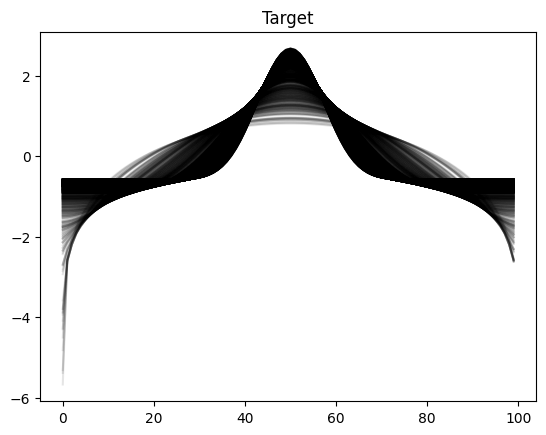

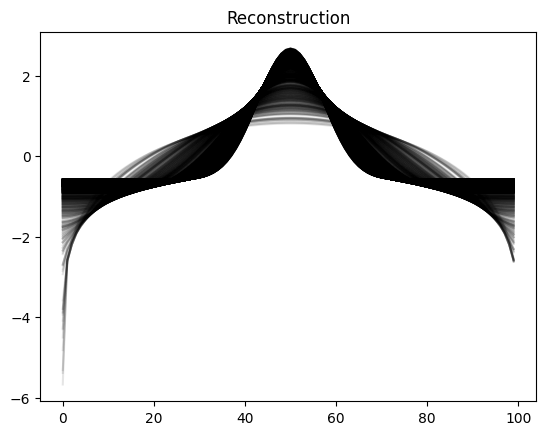

In [8]:
plt.figure(0)
for i in cycle_targets[3]:
    plt.title('Target')
    plt.plot(i, alpha=.1, color='k')
    
    
br = BycycleRecon(affine=False)
br.fit(cycle_targets[3], n_jobs=10)

for i, cyc in enumerate(br.cycles):
    model = getattr(br.models, cyc)
    print(cyc, 'mean loss: ', model.loss.mean())

plt.figure(1)
for j, i in enumerate(br.models.exp_cos.popt):
    kwargs = {k:v for k, v in zip(br.models.exp_cos.param_names, i)}
    plt.plot(sim_normalized_cycle(1, 100, 'exp_cos', **kwargs), color='k', alpha=.1)
plt.title('Reconstruction');

  0%|          | 0/1000 [00:00<?, ?it/s]

sine mean loss:  1.9407642879513571
asine mean loss:  1.9407642879513578
asym_harmonic mean loss:  3.722387178297251
exp_cos mean loss:  0.016053038967271657
gaussian mean loss:  4.3112929808391614e-09
skewed_gaussian mean loss:  0.050724282950797485
sawtooth mean loss:  0.10160963874467277


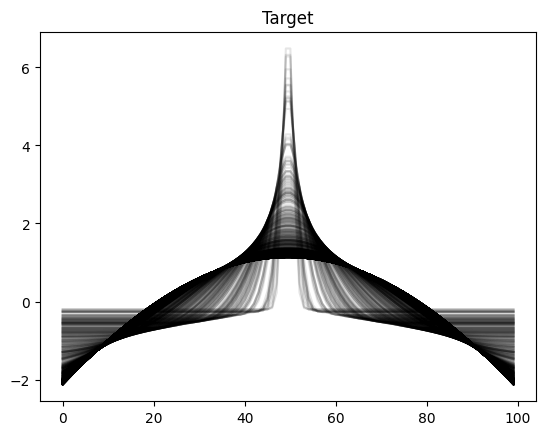

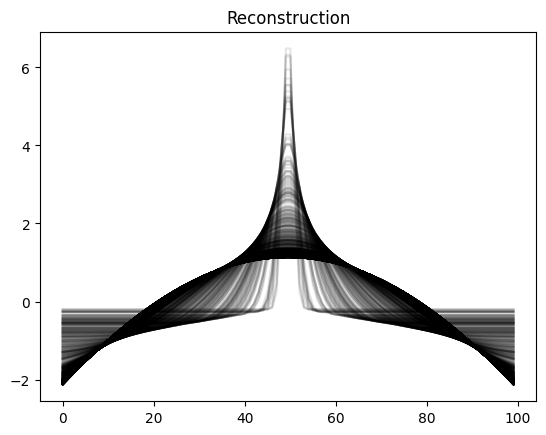

In [9]:
plt.figure(0)
for i in cycle_targets[4]:
    plt.title('Target')
    plt.plot(i, alpha=.1, color='k')
    
    
br = BycycleRecon(affine=False)
br.fit(cycle_targets[4], n_jobs=10)

for i, cyc in enumerate(br.cycles):
    model = getattr(br.models, cyc)
    print(cyc, 'mean loss: ', model.loss.mean())

plt.figure(1)
for j, i in enumerate(br.models.gaussian.popt):
    kwargs = {k:v for k, v in zip(br.models.gaussian.param_names, i)}
    plt.plot(sim_normalized_cycle(1, 100, 'gaussian', **kwargs), color='k', alpha=.1)
plt.title('Reconstruction');

  0%|          | 0/1000 [00:00<?, ?it/s]

sine mean loss:  2.535842854872254
asine mean loss:  2.535842854872254
asym_harmonic mean loss:  2.5959754926733347
exp_cos mean loss:  1.0270842144376184
gaussian mean loss:  1.1083915940725713
skewed_gaussian mean loss:  0.00632876623585643
sawtooth mean loss:  0.3719111396882703


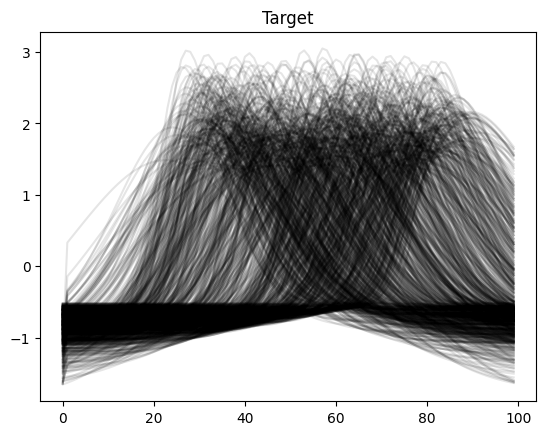

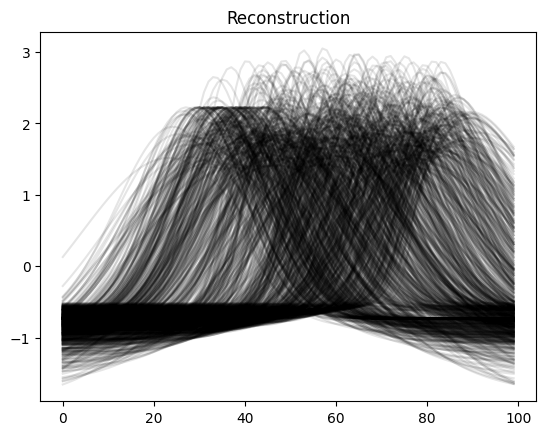

In [10]:
plt.figure(0)
for i in cycle_targets[5]:
    plt.title('Target')
    plt.plot(i, alpha=.1, color='k')
    
    
br = BycycleRecon(affine=False)
br.fit(cycle_targets[5], n_jobs=10)

for i, cyc in enumerate(br.cycles):
    model = getattr(br.models, cyc)
    print(cyc, 'mean loss: ', model.loss.mean())

plt.figure(1)
for j, i in enumerate(br.models.skewed_gaussian.popt):
    kwargs = {k:v for k, v in zip(br.models.skewed_gaussian.param_names, i)}
    plt.plot(sim_normalized_cycle(1, 100, 'skewed_gaussian', **kwargs), color='k', alpha=.1)
plt.title('Reconstruction');

### fix sawtooth (breaks for farish left skew)

  0%|          | 0/1000 [00:00<?, ?it/s]

sine mean loss:  2.0106747545990102
asine mean loss:  2.0106747545990107
asym_harmonic mean loss:  3.0382759402666344
exp_cos mean loss:  0.6542678801918872
gaussian mean loss:  0.7021047880279921
skewed_gaussian mean loss:  0.09353029590404627
sawtooth mean loss:  0.0788722115356158


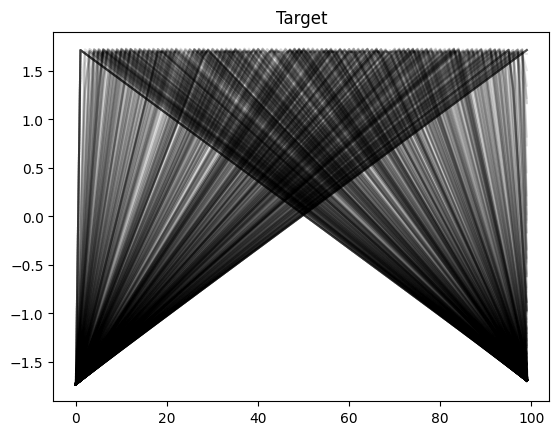

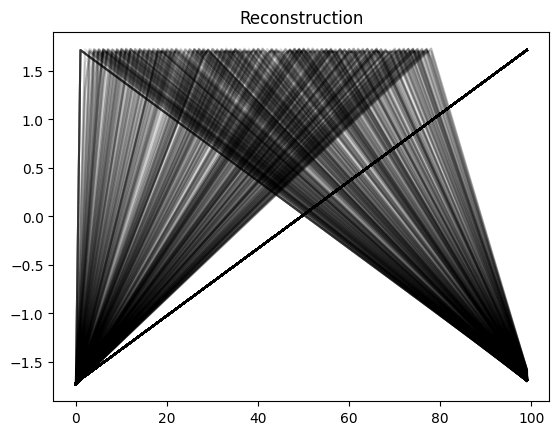

In [11]:
plt.figure(0)
for i in cycle_targets[6]:
    plt.title('Target')
    plt.plot(i, alpha=.1, color='k')
    
    
br = BycycleRecon(affine=False)
br.fit(cycle_targets[6], n_jobs=10)

for i, cyc in enumerate(br.cycles):
    model = getattr(br.models, cyc)
    print(cyc, 'mean loss: ', model.loss.mean())

plt.figure(1)
for j, i in enumerate(br.models.sawtooth.popt):
    kwargs = {k:v for k, v in zip(br.models.sawtooth.param_names, i)}
    plt.plot(sim_normalized_cycle(1, 100, 'sawtooth', **kwargs), color='k', alpha=.1)
plt.title('Reconstruction');

## Fit Real Data

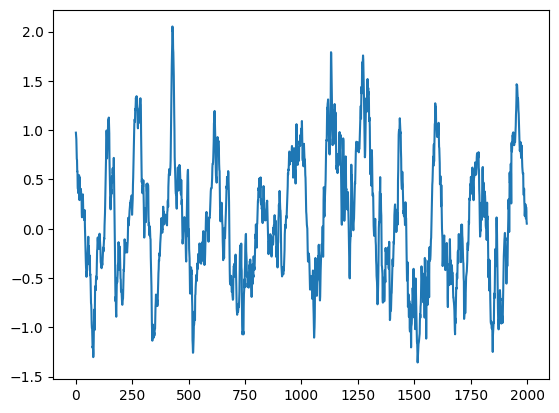

In [12]:
sig = np.load('ca1.npy')
plt.plot(sig[:2000])

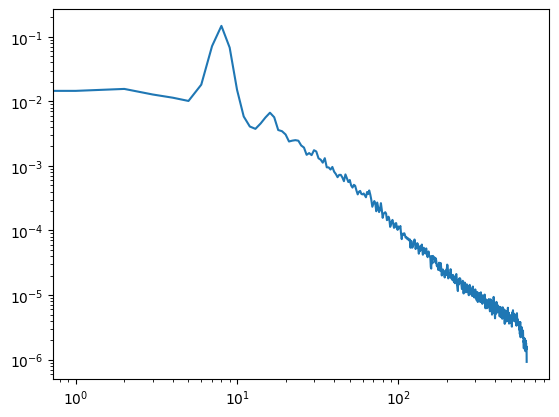

In [13]:
from neurodsp.spectral import compute_spectrum
plt.loglog(*compute_spectrum(sig, 1250))

/Users/ryanhammonds/projects/ndspflow/.env/lib/python3.11/site-packages/bycycle/objs/fit.py:31: UserWarning: 
                No burst detection thresholds are provided. This is not recommended. Please
                inspect your data and choose appropriate parameters for 'thresholds'.
                Default burst detection parameters are likely not well suited for your
                desired application.
                
  warnings.warn("""
/Users/ryanhammonds/projects/ndspflow/.env/lib/python3.11/site-packages/neurodsp/plts/style.py:101: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/ryanhammonds/projects/ndspflow/.env/lib/python3.11/site-packages/neurodsp/plts/style.py:101: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/ryanhammonds/projects/ndspflow/.env/lib/python3.11/site-packages/neurodsp/plts/style.py:101: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/ryanhammonds/projects/nds

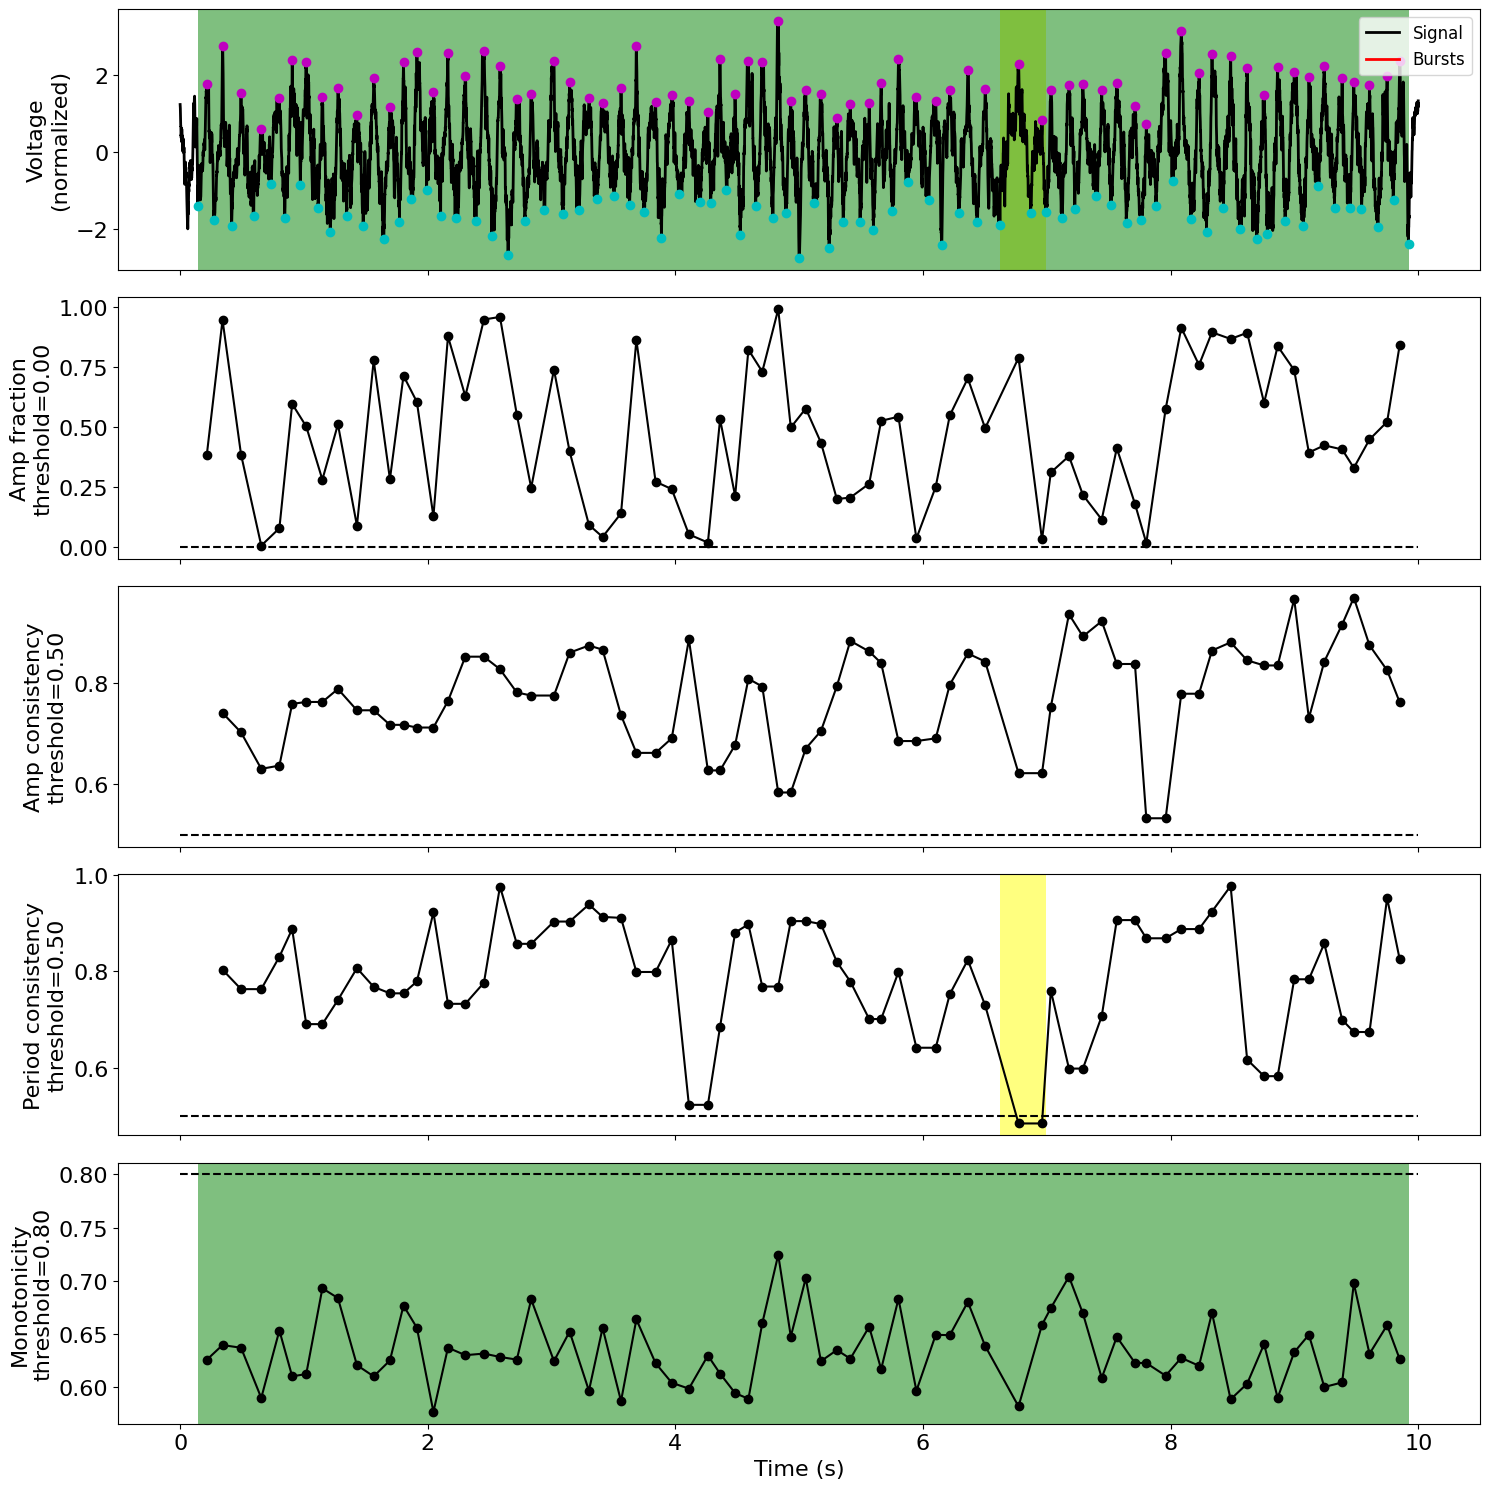

In [14]:
# use bycycle to just get cyclepoints in 4-10hz range
from bycycle import Bycycle
bm = Bycycle(thresholds=None)
bm.fit(sig, 1250, (4, 10))
bm.plot(xlim=(0, 10))

In [15]:
cycles = []

starts = bm.df_features['sample_last_trough']
ends = bm.df_features['sample_next_trough']

for s, e in zip(starts, ends):
    cycles.append(sig[s:e])

In [17]:
# No affine (~5s)
br_ca1 = BycycleRecon(affine=False)
br_ca1.fit(cycles, n_jobs=10)

  0%|          | 0/468 [00:00<?, ?it/s]

In [18]:
# Affine (~49 sec)
br_ca1_affine = BycycleRecon(affine=True)
br_ca1_affine.fit(cycles, n_jobs=10)

  0%|          | 0/468 [00:00<?, ?it/s]

In [19]:
cyc_types = list(br_ca1.models.__dict__.keys())
cyc_types

['sine',
 'asine',
 'asym_harmonic',
 'exp_cos',
 'gaussian',
 'skewed_gaussian',
 'sawtooth']

R-Squared


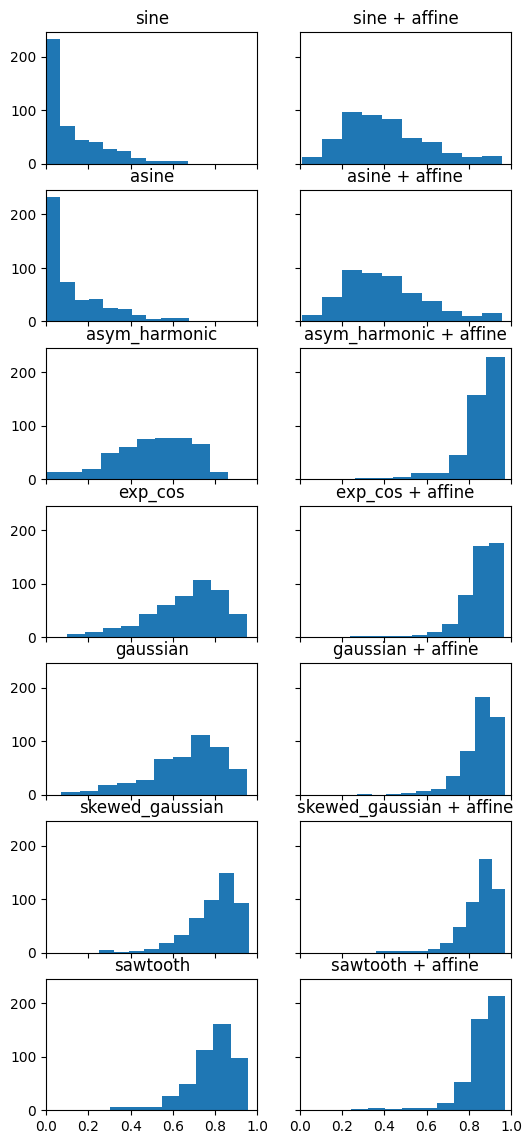

In [20]:
print('R-Squared')

fig, axes = plt.subplots(7, 2, figsize=(6, 14), sharex=True, sharey=True)

for i, ct in enumerate(cyc_types):
    axes[i][0].hist(getattr(br_ca1.models, ct).rsq)
    axes[i][0].set_title(ct)
    axes[i][0].set_xlim(0, 1)

    axes[i][1].hist(getattr(br_ca1_affine.models, ct).rsq)
    axes[i][1].set_title(ct + ' + affine')
    axes[i][1].set_xlim(0, 1)

MSE Loss


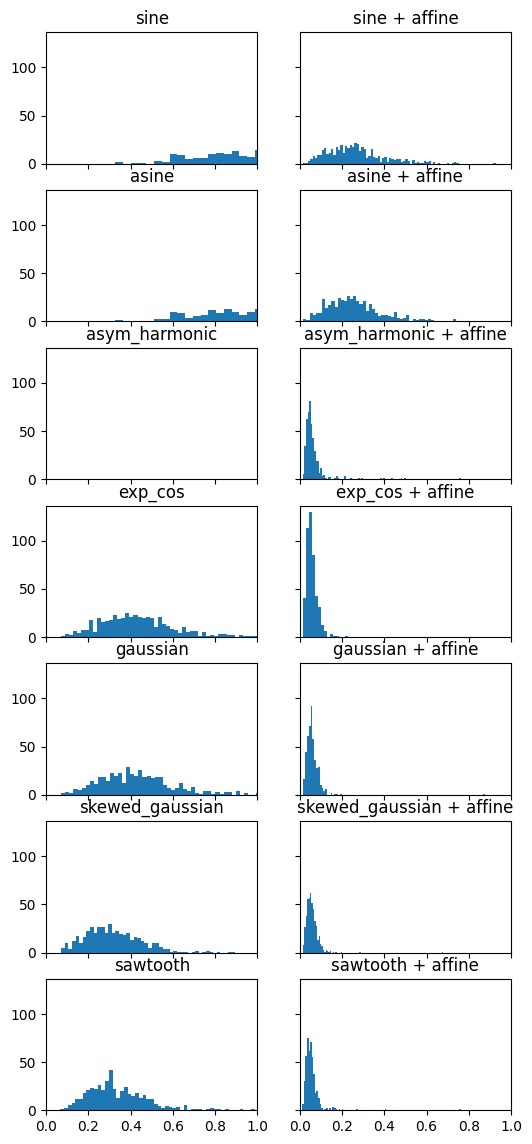

In [21]:
print('MSE Loss')

fig, axes = plt.subplots(7, 2, figsize=(6, 14), sharex=True, sharey=True)

for i, ct in enumerate(cyc_types):
    axes[i][0].hist(getattr(br_ca1.models, ct).loss, bins=100)
    axes[i][0].set_title(ct)
    axes[i][0].set_xlim(0, 1)

    axes[i][1].hist(getattr(br_ca1_affine.models, ct).loss, bins=100)
    axes[i][1].set_title(ct + ' + affine')
    axes[i][1].set_xlim(0, 1)

In [22]:
recon = np.zeros_like(sig)

keys = br_ca1_affine.models.sawtooth.param_names
dtypes = [type(i) for i in br_ca1_affine.models.sawtooth.p0]

for i, p in enumerate(br_ca1_affine.models.sawtooth.popt):
    s = starts[i]
    e = ends[i]

    y_pred = sim_normalized_cycle(
        1, e-s, 'sawtooth',
        **{k: dt(v) for k, dt, v in zip(keys[:-9], dtypes[:-9], p[:-9])}
    )[:e-s]

    x = np.arange(len(y_pred))
    src = np.vstack((x, y_pred)).T
    y_pred = AffineTransform(p[-9:].reshape(3, 3))(src).T[1]

    recon[s:e] = y_pred

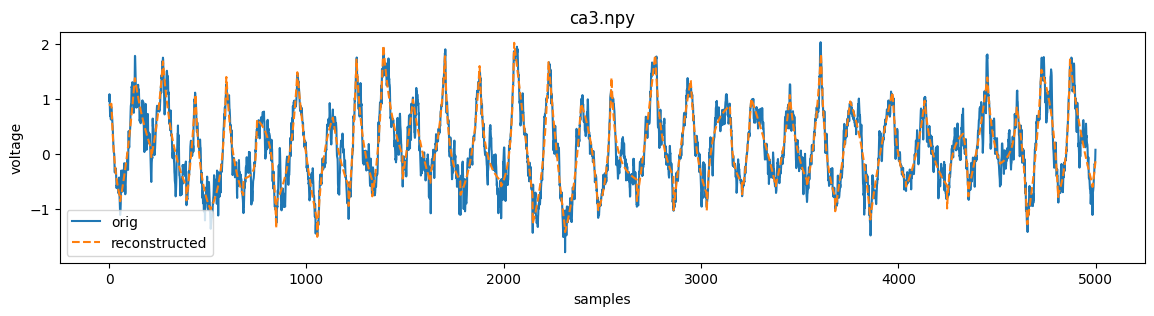

In [23]:
plt.figure(figsize=(14, 3))

plt.plot(sig[1000:6000], label='orig')

plt.plot(recon[1000:6000], ls='--', label='reconstructed')
plt.legend()

plt.title('ca3.npy')
plt.ylabel('voltage')
plt.xlabel('samples')

plt.savefig('recon.png')

In [26]:
print(f'Full Recon R-Squared: {np.corrcoef(sig[1000:-1000], recon[1000:-1000])[0][1]**2}')

Full Recon R-Squared: 0.8848339642149101
